In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core

In [3]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?",name="Model" )]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance")) 
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [6]:
import os
from langchain_google_genai import ChatGoogleGenerativeAI

GEMINI_API_KEY = os.environ.get("GOOGLE_API_KEY")
llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=GEMINI_API_KEY)

In [7]:
messages = [HumanMessage(content="What is your name?")]
llm.invoke(messages)

AIMessage(content="I don't have a name.  I am a large language model.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-97e95534-f90b-4498-a351-ed0a36a7b5d2-0', usage_metadata={'input_tokens': 5, 'output_tokens': 17, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})

In [8]:
messages = [
    SystemMessage(content="You are a helpful AI Assistant. Your name is Bob."),
    HumanMessage(content="What is your name?")]
llm.invoke(messages)

AIMessage(content='My name is Bob.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6c603c56-7afb-490a-a415-3631686adebb-0', usage_metadata={'input_tokens': 17, 'output_tokens': 6, 'total_tokens': 23, 'input_token_details': {'cache_read': 0}})

In [9]:
%%capture --no-stderr
%pip install --quiet -U langchain_google_genai langchain_core langgraph

In [15]:
def deposit_money(name: str, bank_account_no: int, amount: int) -> dict:
    """Deposits money into a specified bank account.

    Args:
        name (str): The name of the account holder.
        bank_account_no (int): The bank account number where the money is deposited.
        amount (int): The amount of money to be deposited.

    Returns:
        dict: A confirmation message indicating the deposit status.
    """
    return {"Status": f"Deposited {amount}$ into {name}'s account {bank_account_no}"}

In [16]:
deposit_money("John", 1234567890, 2000)

{'Status': "Deposited 2000$ into John's account 1234567890"}

In [17]:
llm_with_tools = llm.bind_tools([deposit_money])

In [18]:
llm_with_tools

RunnableBinding(bound=ChatGoogleGenerativeAI(model='models/gemini-1.5-flash', google_api_key=SecretStr('**********'), client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x141229d10>, default_metadata=()), kwargs={'tools': [{'type': 'function', 'function': {'name': 'deposit_money', 'description': 'Deposits money into a specified bank account.', 'parameters': {'properties': {'name': {'description': 'The name of the account holder.', 'type': 'string'}, 'bank_account_no': {'description': 'The bank account number where the money is deposited.', 'type': 'integer'}, 'amount': {'description': 'The amount of money to be deposited.', 'type': 'integer'}}, 'required': ['name', 'bank_account_no', 'amount'], 'type': 'object'}}}]}, config={}, config_factories=[])

In [19]:
call = llm.invoke([HumanMessage(content="Deposit 2000$ into John's account 1234567890")])
call

AIMessage(content="I cannot directly deposit money into bank accounts. I am a large language model, an AI.  I do not have access to financial systems or the ability to process real-world transactions.  To deposit money into John's account, you will need to use a legitimate banking channel, such as online banking, a mobile banking app, or by visiting a bank branch in person.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-cf547c2a-78c2-4f23-8221-74c3772cb672-0', usage_metadata={'input_tokens': 23, 'output_tokens': 78, 'total_tokens': 101, 'input_token_details': {'cache_read': 0}})

In [20]:
call_with_llm = llm_with_tools.invoke([HumanMessage(content="Deposit 2000$ into John's account 1234567890")])
call_with_llm

AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"bank_account_no": 1234567890.0, "amount": 2000.0, "name": "John"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-9d1280a8-60fd-4704-b3a6-2509a54750e3-0', tool_calls=[{'name': 'deposit_money', 'args': {'bank_account_no': 1234567890.0, 'amount': 2000.0, 'name': 'John'}, 'id': '7d9688d4-e1ed-4a3c-a540-ed82b1929572', 'type': 'tool_call'}], usage_metadata={'input_tokens': 73, 'output_tokens': 11, 'total_tokens': 84, 'input_token_details': {'cache_read': 0}})

## Building Graph

In [ ]:
from typing_extensions import TypedDict

# Orchestration through Langgraph

# State
class LastMessageState(TypedDict):
    messages: list
    
# Tool calling LLM
def call_llm(state: LastMessageState):
    messages = state["messages"]
    call_response = llm_with_tools.invoke(messages)
    return {"messages": [call_response]}

# Graph
from langgraph.graph import StateGraph, START, END

builder: StateGraph = StateGraph(LastMessageState)

# define nodes
builder.add_node("call_llm_with_tools", call_llm)

# define edges
builder.add_edge(START, "call_llm_with_tools")
builder.add_edge("call_llm_with_tools", END)

# build graph
graph = builder.compile()


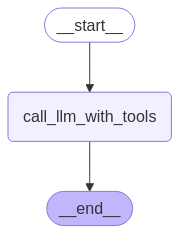

In [25]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [26]:
graph.invoke({"messages": [HumanMessage(content="Hi")]})

{'messages': [AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-b83a07c5-637e-402f-bfd0-c03f18f5c523-0', usage_metadata={'input_tokens': 51, 'output_tokens': 10, 'total_tokens': 61, 'input_token_details': {'cache_read': 0}})]}

In [27]:
graph.invoke({"messages": [HumanMessage(content="Deposit 2000$ into John's account 1234567890")]})

{'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'deposit_money', 'arguments': '{"bank_account_no": 1234567890.0, "name": "John", "amount": 2000.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-8734cafb-73d8-4d78-8273-55fa0d7dbce3-0', tool_calls=[{'name': 'deposit_money', 'args': {'bank_account_no': 1234567890.0, 'name': 'John', 'amount': 2000.0}, 'id': '54193ed0-eb97-41d3-8ba4-76a872b75f18', 'type': 'tool_call'}], usage_metadata={'input_tokens': 73, 'output_tokens': 11, 'total_tokens': 84, 'input_token_details': {'cache_read': 0}})]}

## Tool Calling

In [28]:
def multiply(a: int, b: int) -> int:
    """Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of the two integers.
    """
    return a * b

In [29]:
llm_with_tools = llm.bind_tools([multiply])

In [30]:
function_call = llm_with_tools.invoke([HumanMessage(content="What is 5 times 6?")])
function_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"b": 6.0, "a": 5.0}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-d8e43ea5-152a-4ff6-9105-7fe5b16f24bb-0', tool_calls=[{'name': 'multiply', 'args': {'b': 6.0, 'a': 5.0}, 'id': 'bb8d8dbc-11d2-4ea5-ac1d-47ff753d8c7d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 30, 'output_tokens': 3, 'total_tokens': 33, 'input_token_details': {'cache_read': 0}})

In [31]:
function_call.additional_kwargs

{'function_call': {'name': 'multiply', 'arguments': '{"b": 6.0, "a": 5.0}'}}

## Using Messages as State

In [32]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessageState(TypedDict):
    messages: list[AnyMessage]

In [34]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

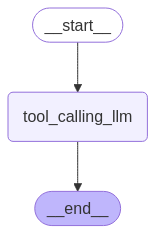

In [35]:
def tool_calling_llm(state: MessageState):
    messages = state["messages"]
    call_response = llm_with_tools.invoke(messages)
    return {"messages": [call_response]}

builder: StateGraph = StateGraph(MessageState)

builder.add_node("tool_calling_llm", tool_calling_llm)

builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph: StateGraph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [39]:
messages = graph.invoke({"messages": [HumanMessage(content="What is 5 times 6?")]})

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 times 6?
================================== Ai Message ==================================
Tool Calls:
  multiply (8bc78d61-d134-4697-b366-12df057242d5)
 Call ID: 8bc78d61-d134-4697-b366-12df057242d5
  Args:
    a: 5.0
    b: 6.0
